<a href="https://colab.research.google.com/github/marius44/Roary/blob/master/Uni_Dock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hi there!**

This is a Jupyter notebook for running molecular docking calculations with Uni-Dock, a GPU-accelerated molecular docking program.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to perform drug binding structure prediction in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for docking calculations and MD simulations!** It is just simple docking pipeline illustrating each step of a docking and MD protocol.

---


**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/Cloud-Bind/issues

**Acknowledgments**
- We would like to thank the [Uni-Dock](https://github.com/dptech-corp/Uni-Dock) team for doing an excellent job open sourcing the software.
- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).
- We would like to thank [@ruiz_moreno_aj](https://twitter.com/ruiz_moreno_aj) for his work on [Jupyter Dock](https://github.com/AngelRuizMoreno/Jupyter_Dock)
- We would like to thank the ChemosimLab ([@ChemosimLab](https://twitter.com/ChemosimLab)) team for their incredible [ProLIF](https://prolif.readthedocs.io/en/latest/index.html#) (Protein-Ligand Interaction Fingerprints) tool.
- We would like to thank the [OpenBPMD](https://github.com/Gervasiolab/OpenBPMD) team for their open source implementation of binding pose metadynamics (BPMD).
- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.
- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.
- A Cloud-Bind by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes))

- For related notebooks see: [Cloud-Bind](https://github.com/pablo-arantes/Cloud-Bind)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
import tarfile
import os

import subprocess
import sys

commands = [
    "rm -rf /usr/local/conda-meta/pinned",
    "pip -q install py3Dmol",
    "pip install git+https://github.com/pablo-arantes/biopandas",
    "pip install bio",
    "mamba install pytorch torchvision -c pytorch",
    "pip install torchani",
    "pip install ase",
    "mamba install -c conda-forge pdbfixer -y",
    "mamba install -c conda-forge parmed -y",
    "mamba install -c conda-forge openbabel -y",
    "mamba install -c conda-forge rdkit -y",
    "wget https://github.com/dptech-corp/Uni-Dock/releases/download/1.0.0/unidock",
    "chmod +x unidock",
    "wget https://github.com/rdk/p2rank/releases/download/2.4/p2rank_2.4.tar.gz"
]

for cmd in commands:
    subprocess.run(cmd, shell=True)

file = tarfile.open('p2rank_2.4.tar.gz')
file.extractall('/content/')
file.close()
os.remove('p2rank_2.4.tar.gz')


#load dependencies
import parmed as pmd
from biopandas.pdb import PandasPdb
import urllib.request
import numpy as np
import py3Dmol
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [2]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Feb 19 23:39:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----


---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed.

**Important**: Make sure the PDB file points to the correct structure.

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.

**Please, don't use spaces in the files and folders names, i.e. MyDrive/protein_ligand and so on.**

In [4]:
#@title **Please, provide the necessary input files below for receptor**:
#@markdown **Important:** Run the cell to prepare your receptor and select your reference residue for the construction of an optimal box size for the docking calculations.
from openmm.app.pdbfile import PDBFile

import warnings
warnings.filterwarnings('ignore')
import os
from Bio.PDB import PDBParser, PDBIO, Select
from Bio.PDB import is_aa
import pandas as pd
from pdbfixer import PDBFixer
from openbabel import pybel

Google_Drive_Path = '/content/' #@param {type:"string"}
workDir = Google_Drive_Path

workDir2 = os.path.join(workDir)
workDir_check = os.path.exists(workDir2)
if workDir_check == False:
  os.mkdir(workDir2)
else:
  pass

if os.path.exists(os.path.join(workDir, "name_residues.txt")):
  os.remove(os.path.join(workDir, "name_residues.txt"))
  os.remove(os.path.join(workDir,"name_residues_receptor.txt"))
else:
  pass

temp = os.path.join(workDir, "temp.pdb")
receptor = os.path.join(workDir, "receptor.pdb")
receptor_pdbqt = os.path.join(workDir, "receptor.pdbqt")
ligand = os.path.join(workDir, "ligand.pdbqt")


Query_PDB_ID = '3HTB' #@param {type:"string"}

pdbfn = Query_PDB_ID + ".pdb"
url = 'https://files.rcsb.org/download/' + pdbfn
outfnm = os.path.join(workDir, pdbfn)
urllib.request.urlretrieve(url, outfnm)


ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.to_pdb(path=temp, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

#prepare receptor
ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=receptor, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

fixer = PDBFixer(filename=receptor)
fixer.removeHeterogens()
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH=7.4)
PDBFile.writeFile(fixer.topology, fixer.positions, open(receptor, 'w'))

path = '/content/'


def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"

def aa(residue):
    res = residue.id[0]
    return res != "W"


class ResidueSelect(Select):
    def __init__(self, chain, residue):
        self.chain = chain
        self.residue = residue

    def accept_chain(self, chain):
        return chain.id == self.chain.id

    def accept_residue(self, residue):
        return residue == self.residue and aa(residue)

def extract_ligands(path):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues.txt"), "a",))
          i += 1

extract_ligands(path)

def extract_ligands2(path):
    pdb = PDBParser().get_structure(receptor, receptor)
    io = PDBIO()
    io.set_structure(pdb)
    i2 = 1
    name_residues2 = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues2.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues_receptor.txt"), "a",))
          i2 += 1

extract_ligands2(path)

# mol= [m for m in pybel.readfile(filename=receptor, format='pdb')][0]
# out=pybel.Outputfile(filename=receptor_pdbqt,format='pdbqt',overwrite=True)
# pybel.Molecule()
# out.write(mol)
# out.close()

os.system("obabel -i pdb " + str(receptor) + " -o pdbqt -O " + str(receptor_pdbqt) + " -xr --partialcharge")

dataset = pd.read_csv(os.path.join(workDir, 'name_residues.txt'), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

dataset2 = pd.read_csv(os.path.join(workDir, 'name_residues_receptor.txt'), delimiter = " ", header=None)
df2 = pd.DataFrame(dataset2)
df2 = df2.iloc[:, [2]]
new2 = df2.to_numpy()

b = 1
res_number = []
for j in new2:
  res_number.append(b)
  b += 1

print("Residue" + " - "  + "Number" )
a = 1
for j in new:
  print(', '.join(j) + " - "  + str(a))
  a += 1

Residue - Number
MET - 1
ASN - 2
ILE - 3
PHE - 4
GLU - 5
MET - 6
LEU - 7
ARG - 8
ILE - 9
ASP - 10
GLU - 11
GLY - 12
LEU - 13
ARG - 14
LEU - 15
LYS - 16
ILE - 17
TYR - 18
LYS - 19
ASP - 20
THR - 21
GLU - 22
GLY - 23
TYR - 24
TYR - 25
THR - 26
ILE - 27
GLY - 28
ILE - 29
GLY - 30
HIS - 31
LEU - 32
LEU - 33
THR - 34
LYS - 35
SER - 36
PRO - 37
ASP - 38
LEU - 39
ASN - 40
ALA - 41
ALA - 42
LYS - 43
SER - 44
GLU - 45
LEU - 46
ASP - 47
LYS - 48
ALA - 49
ILE - 50
GLY - 51
ARG - 52
ASN - 53
CYS - 54
ASN - 55
GLY - 56
VAL - 57
ILE - 58
THR - 59
LYS - 60
ASP - 61
GLU - 62
ALA - 63
GLU - 64
LYS - 65
LEU - 66
PHE - 67
ASN - 68
GLN - 69
ASP - 70
VAL - 71
ASP - 72
ALA - 73
ALA - 74
VAL - 75
ARG - 76
GLY - 77
ILE - 78
LEU - 79
ARG - 80
ASN - 81
ALA - 82
LYS - 83
LEU - 84
LYS - 85
PRO - 86
VAL - 87
TYR - 88
ASP - 89
SER - 90
LEU - 91
ASP - 92
ALA - 93
VAL - 94
ARG - 95
ARG - 96
CYS - 97
ALA - 98
ALA - 99
ILE - 100
ASN - 101
GLN - 102
VAL - 103
PHE - 104
GLN - 105
MET - 106
GLY - 107
GLU - 108
THR - 109
G

In [5]:
#@title **Predict ligand-binding pockets from your protein structure using P2Rank**:
#@markdown **P2Rank** is a stand-alone command line program that predicts ligand-binding pockets from a protein structure. It achieves high prediction success rates without relying on an external software for computation of complex features or on a database of known protein-ligand templates.
#@markdown P2Rank makes predictions by scoring and clustering points on the protein's solvent accessible surface. Ligandability score of individual points is determined by a machine learning based model trained on the dataset of known protein-ligand complexes. For more details see [here](https://github.com/rdk/p2rank).

import subprocess
import csv

output_p2rank = os.path.join(workDir, "output_p2rank")
p2rank = "/content/p2rank_2.4/prank predict -f " + str(receptor) + " -o " + str(output_p2rank)
original_stdout = sys.stdout
with open('p2rank.sh', 'w') as f:
  sys.stdout = f
  print(p2rank)
  sys.stdout = original_stdout
subprocess.run(["chmod 700 p2rank.sh"], shell=True)
subprocess.run(["./p2rank.sh"], shell=True,)

with open(os.path.join(workDir, "output_p2rank/receptor.pdb_predictions.csv"), 'r') as file:
  csvreader = csv.reader(file)
  residue = []
  score = []
  center_x = []
  center_y = []
  center_z = []
  for row in csvreader:
    residue.append(row[9:10])
    score.append(row[2:3])
    center_x.append(row[6:7])
    center_y.append(row[7:8])
    center_z.append(row[8:9])

for i in range(1,len(residue)):
  file = str((residue[i])[0]).split()
  score_end = str((score[i])[0]).split()
  center_x_end = str((center_x[i])[0]).split()
  center_y_end = str((center_y[i])[0]).split()
  center_z_end = str((center_z[i])[0]).split()
  print("Pocket " + str(i))
  print("Score = " + score_end[0])
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  print("Selected Residues = " + str(final_residues))
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")

Pocket 1
Score = 13.61
Selected Residues = [10, 103, 104, 105, 106, 107, 108, 11, 137, 138, 141, 142, 145, 18, 20, 21, 22, 24, 26, 30, 31, 32, 35, 70, 73, 74, 77]
Center x = 26.9061 Center y = -13.2369 Center z = -10.2065

Pocket 2
Score = 3.53
Selected Residues = [102, 103, 111, 118, 121, 153, 78, 84, 87, 88, 91, 99]
Center x = 22.5540 Center y = -25.4592 Center z = -2.7213

Pocket 3
Score = 2.13
Selected Residues = [100, 3, 71, 75, 88, 96, 97]
Center x = 14.4580 Center y = -23.6512 Center z = -13.2428



In [6]:
#@title **Please, provide the pocket or residue number for the selection**:
#@markdown **Important:** The selected pocket or residues will be used as a reference for the construction of an optimal box size for the ligand during the docking. If you want to select more than one residue, please, use comma to separte the numbers (i.e. 147,150,155,160). **Please, DO NOT USE SPACES BETWEEN THEM.**

import re
import csv

if os.path.exists(os.path.join(workDir, "name_residue.txt")):
  os.remove(os.path.join(workDir, "name_residue.txt"))
else:
  pass

# Python code to convert string to list
def Convert(string):
	li = list(string.split(","))
	return li

def extract_ligands(path,residues):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          if i == int(residues):
            # print(residues)
            print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residue.txt"), "a",))
            io.save(f"res_{i}_certo.pdb", ResidueSelect(chain, residue))
          i += 1

Selection = "Pocket" #@param ["Pocket", "Residues"]

number = '3' #@param {type:"string"}

if Selection == "Pocket":
  file = str((residue[int(number)])[0]).split()
  score_end = str((score[int(number)])[0]).split()
  center_x_end = str((center_x[int(number)])[0]).split()
  center_y_end = str((center_y[int(number)])[0]).split()
  center_z_end = str((center_z[int(number)])[0]).split()
  center_x_gnina = float(center_x_end[0])
  center_y_gnina = float(center_y_end[0])
  center_z_gnina = float(center_z_end[0])
  print("Pocket " + str(number))
  print("Score = " + score_end[0])
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  residues_num = final_residues
else:
  residues_num = Convert(number)

filenames=[]
for k in range(0, len(residues_num)):
  extract_ligands(path, residues_num[k])
  filenames.append(f"res_{residues_num[k]}_certo.pdb")


with open('selection_merge.pdb', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

# reading each line from original
# text file
file1 = open('/content/selection_merge.pdb', 'r')
file2 = open('/content/selection_merge_end.pdb','w')

for line in file1.readlines():

    # reading all lines that begin
    # with "TextGenerator"
    x = re.findall("^END", line)

    if not x:
        file2.write(line)

# close and save the files
file1.close()
file2.close()

dataset = pd.read_csv(os.path.join(workDir, "name_residue.txt"), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

print("Selected Residue" + " - "  + "Number" )
for j, i in zip(new, range(0, len(residues_num))):
# for j in new:
  print(', '.join(j) + " - "  + str(residues_num[i]))
res_box = '/content/selection_merge_end.pdb'

Pocket 3
Score = 2.13
Center x = 14.4580 Center y = -23.6512 Center z = -13.2428

Selected Residue - Number
ILE - 100
ILE - 3
VAL - 71
VAL - 75
TYR - 88
ARG - 96
CYS - 97


In [7]:
#@title **Setting the grid box**:
#@markdown Now, we will use our ViewProtGrid to visualize the protein, binding site residues and a grid box of variable size and position that we can manipulate using a slider.

#These definitions will enable loading our protein and then
#drawing a box with a given size and centroid on the cartesian space
#This box will enable us to set up the system coordinates for the simulation
#
#HINT: The active site of the HIV-2 protease is near the beta strands in green
#
#ACKNOWLEDGE: This script is largely based on the one created by Jose Manuel
#Napoles Duarte, Physics Teacher at the Chemical Sciences Faculty of the
#Autonomous University of Chihuahua (https://github.com/napoles-uach)
#
#First, we define the grid box
def definegrid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({'center':{'x':bxi,'y':byi,'z':bzi},'dimensions': {'w':bxf,'h':byf,'d':bzf},'color':'blue','opacity': 0.6})

#Next, we define how the protein will be shown in py3Dmol
#Note that we are also adding a style representation for active site residues
def viewprot(object,prot_PDBfile):
  mol1 = open(prot_PDBfile, 'r').read()
  object.addModel(mol1,'pdb')
  object.setStyle({'cartoon': {'color':'white'}})

# def viewresid(res_box)
#   mol2 = (open(res_box,'r').read(),format='mol2')

#Lastly, we combine the box grid and protein into a single viewer
def viewprotgrid(prot_PDBfile,resids,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  mol_view = py3Dmol.view(1000,600)
  definegrid(mol_view,bxi,byi,bzi,bxf,byf,bzf)
  viewprot(mol_view,prot_PDBfile)
  mol_view.addModel(open(resids,'r').read(),format='mol2')
  ref_m = mol_view.getModel()
  ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})
  mol_view.setBackgroundColor('0xffffff')
  mol_view.zoomTo()
  mol_view.show()

#@markdown X coordinate of the center (Angstrom):
centerX = 23 #@param {type:"slider", min:-100, max:100, step:1}
#@markdown Y coordinate of the center (Angstrom):
centerY = -25 #@param {type:"slider", min:-100, max:100, step:1}
#@markdown Z coordinate of the center (Angstrom):
centerZ = -3 #@param {type:"slider", min:-100, max:100, step:1}
#@markdown Size in the X dimension (Angstrom):
sizeX = 10 #@param {type:"slider", min:0, max:30, step:1}
#@markdown Size in the Y dimension (Angstrom):
sizeY = 10 #@param {type:"slider", min:0, max:30, step:1}
#@markdown Size in the Z dimension (Angstrom):
sizeZ = 10 #@param {type:"slider", min:0, max:30, step:1}

viewprotgrid(receptor,res_box,centerX,centerY,centerZ,sizeX,sizeY,sizeZ)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Smiles: CCCC1=CC=CC=C1O


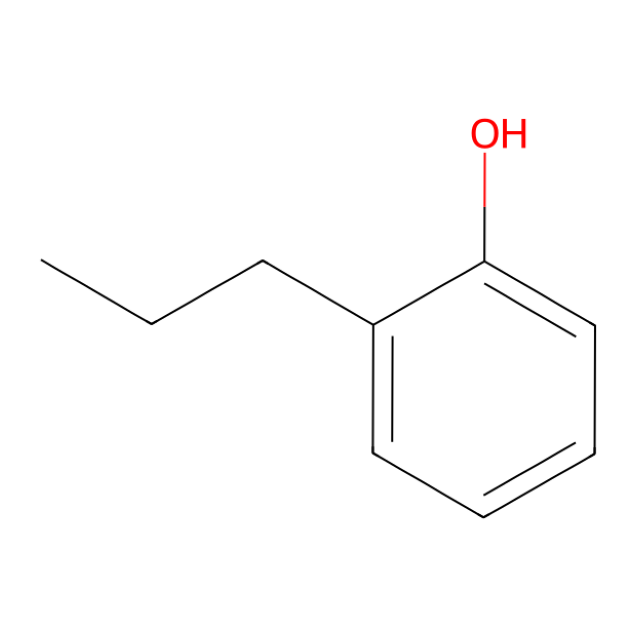

In [8]:
#@title **Please, provide the necessary input files for the ligand**:

#@markdown Type the smiles or filename (PDB and MOL formats) of your molecule. **Ex: C=CC(=O)OC, molecule.pdb or molecule.mol**

#@markdown Just remind you that if you want to use pdb or mol file, you should first upload the file here in Colab or in your Google Drive.

#@markdown If you don't know the exactly smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import matplotlib.image as mpimg

import os

import py3Dmol


Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'CCCC1=CC=CC=C1O' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles_or_filename
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
elif Type == "pdb":
  pdb_name = os.path.join(workDir, smiles_or_filename)
  mol= [m for m in pybel.readfile(filename=pdb_name, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
else:
  mol_name = os.path.join(workDir, smiles_or_filename)
  mol = Chem.MolFromMolFile(mol_name)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))

print("Smiles: " + str(Smiles))
smi = Draw.MolToFile(smiles_fig, size=(600, 600), filename=os.path.join(workDir,str(Smiles) + '.png'))
img = mpimg.imread(os.path.join(workDir,str(Smiles) + '.png'))
plt.figure(figsize = (8,8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
from openbabel import pybel
from torchani.units import HARTREE_TO_KCALMOL


#@title **Ligand geometry optimization using TorchANI**:

#@markdown Geometry optimization for the ligand 3D structure, using ANI-1x, ANI-1ccx or ANI-2x as the optimizing engine.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

model_name = "ANI-1x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}



# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand.mol")), removeHs=False)
mol = io.read(os.path.join(workDir, "ligand.mol"))
coordinates, species = mol2arr([mol_deg], device)
tensor1 = coordinates.detach().numpy()
atoms = Atoms(mol, positions=tensor1[0])
atoms.center(vacuum=3.0)
atoms.set_calculator(calculator)
print("Begin Geometry Optimization ")
opt = BFGS(atoms)
opt.run(fmax=opt_tol)
# print()
write((os.path.join(workDir, "ligand_min.xyz")), format="xyz", images=atoms)

atomic_symbols = []
xyz_coordinates = []

with open((os.path.join(workDir, "ligand_min.xyz")), "r") as file:
  for line_number,line in enumerate(file):
      if line_number == 0:
          num_atoms = int(line)
      elif line_number == 1:
          comment = line # might have useful information
      else:
          atomic_symbol, x, y, z = line.split()
          atomic_symbols.append(atomic_symbol)
          xyz_coordinates.append([float(x),float(y),float(z)])

from rdkit.Geometry import Point3D
conf = mol_deg.GetConformer()

for i in range(mol_deg.GetNumAtoms()):
  x,y,z = xyz_coordinates[i]
  conf.SetAtomPosition(i,Point3D(x,y,z))
AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "ligand_min.mol")))
AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "ligand_min.pdb")))
#convert to sdf format
# mol= [m for m in pybel.readfile(filename=os.path.join(workDir, "ligand_min.mol"), format='mol')][0]
# out=pybel.Outputfile(filename=ligand,format='pdbqt',overwrite=True)
# out.Molecule()
# out.write(mol)
# out.close()
ligand_mol=os.path.join(workDir, "ligand_min.mol")
os.system("obabel -i mol " + str(ligand_mol) + " -o pdbqt -O " + str(ligand) + " -xh --partialcharge")

#TorchANI Energies
mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand_min.mol")), removeHs=False)
coordinates, species = mol2arr([mol_deg], device)
energy = model((species, coordinates)).energies
derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
force = -derivative
print('Energy:', energy.item())
# print('Force:', force.squeeze())

/usr/local/lib/python3.11/site-packages/torchani/resources/
/usr/local/lib/python3.11/site-packages/torchani/resources/
Model = ANI1x
Begin Geometry Optimization 
      Step     Time          Energy          fmax
BFGS:    0 23:44:41   -11572.885146        0.728160
BFGS:    1 23:44:41   -11572.894967        0.349268
BFGS:    2 23:44:41   -11572.901514        0.249812
BFGS:    3 23:44:41   -11572.908820        0.203796
BFGS:    4 23:44:41   -11572.912127        0.187997
BFGS:    5 23:44:41   -11572.915178        0.122942
BFGS:    6 23:44:41   -11572.917142        0.118263
BFGS:    7 23:44:41   -11572.918695        0.110356
BFGS:    8 23:44:41   -11572.919862        0.107019
BFGS:    9 23:44:41   -11572.920872        0.091633
BFGS:   10 23:44:41   -11572.921997        0.093857
BFGS:   11 23:44:41   -11572.923098        0.098751
BFGS:   12 23:44:41   -11572.923841        0.057379
BFGS:   13 23:44:41   -11572.924213        0.047577
BFGS:   14 23:44:41   -11572.924407        0.034617
BFGS:  

In [10]:
#@title **Ligand Visualization**:
#@markdown Now the ligand has been optimized, it would be recomended to visualize and check the ligand.

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

# view.addModel(open(receptor,'r').read(),format='pdb')
# Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open(os.path.join(workDir, "ligand_min.mol"),'r').read(),format='pdbqt')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
#@title **Parameters for the docking calculation:**

#@markdown Explicit random seed:
seed = "0" #@param {type:"string"}

scoring = "vina" #@param ["vina", "vinardo"]


#@markdown **Advanced options** `--search_mode` is the recommended setting of `--exhaustiveness` and `--max_step`, with three combinations called `fast`, `balance`, and `detail`.

#@markdown - `fast` mode: `--exhaustiveness 128` & `--max_step 20`
#@markdown - `balance` mode: `--exhaustiveness 384` & `--max_step 40`
#@markdown - `detail` mode: `--exhaustiveness 512` & `--max_step 40`

#@markdown The larger `--exhaustiveness` and `--max_step`, the higher the computational complexity, the higher the accuracy, but the larger the computational cost.

search_mode = "fast" #@param ["fast", "balance", "detail"]
exhaustiveness = 128 #@param {type:"slider", min:8, max:512, step:8}
max_step = 20 #@param {type:"slider", min:0, max:40, step:5}

#@markdown Maximum number of binding modes to generate:
num_modes = 10 #@param {type:"slider", min:1, max:10, step:1}

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

unidock = "./unidock --receptor " + str(receptor_pdbqt) + " --gpu_batch " + str(ligand) + " --search_mode " + str(search_mode) + " --scoring " + str(scoring) + " --center_x " + str(centerX) + " --center_y " + str(centerY) + " --center_z " + str(centerZ) + " --size_x " + str(sizeX) + " --size_y " + str(sizeY) + " --size_z " + str(sizeZ) + " --num_modes " + str(num_modes) + " --dir " + str(workDir) + " --seed " + str(seed) + " --max_step " + str(max_step) + " --exhaustiveness " + str(exhaustiveness)

original_stdout = sys.stdout # Save a reference to the original standard output
with open('unidock.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(unidock)
    sys.stdout = original_stdout # Reset the standard output to its original value
print(unidock)
!chmod 700 unidock.sh 2>&1 1>/dev/null
!bash unidock.sh

ligand_out=os.path.join(workDir, "ligand_out.pdbqt")
ligand_out_sdf=os.path.join(workDir, "ligand_out.sdf")
os.system("obabel -i pdbqt " + str(ligand_out) + " -o sdf -O " + str(ligand_out_sdf) + " -xh")


import gzip
v = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
v.setViewStyle({'style':'outline','color':'black','width':0.05})
v.addModel(open(receptor).read())
v.setStyle({'cartoon':{},'stick':{'colorscheme':'white','radius':.1}})
v.addModel(open(res_box).read())
v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.175}})
v.addModelsAsFrames(open(ligand_out_sdf,'rt').read())
v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon'}})
v.animate({'interval':1000})
v.zoomTo({'model':1})
v.rotate(90)

./unidock --receptor /content/receptor.pdbqt --gpu_batch /content/ligand.pdbqt --search_mode fast --scoring vina --center_x 23 --center_y -25 --center_z -3 --size_x 10 --size_y 10 --size_z 10 --num_modes 10 --dir /content/ --seed 0 --max_step 20 --exhaustiveness 128
Uni-Dock v0.1.0

If you used Uni-Dock in your work, please cite:               
 
Yu, Y., Cai, C., Wang, J., Bo, Z., Zhu, Z., & Zheng, H. (2023). 
Uni-Dock: GPU-Accelerated Docking Enables Ultralarge Virtual Screening. 
Journal of Chemical Theory and Computation.                    
https://doi.org/10.1021/acs.jctc.2c01145                       

Tang, S., Chen, R., Lin, M., Lin, Q., Zhu, Y., Ding, J., ... & Wu, J. (2022). 
Accelerating autodock vina with gpus. Molecules, 27(9), 3041. 
DOI 10.3390/molecules27093041                                 

J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  
AutoDock Vina 1.2.0: New Docking Methods, Expanded Force      
Field, and Python Bindings, J. Chem. Inf. Model. (20

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
#@title **Best pose selection:**

mode_number = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

view.addModel(open(receptor,'r').read(),'pdb')
Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'},'stick':{'radius':.1}})
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.2,'color':'white'})


view.addModel(open(res_box,'r').read(),'pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'grayCarbon','radius':0.2}})


results=Chem.SDMolSupplier(ligand_out_sdf,False)
p=Chem.MolToMolBlock(results[(int(mode_number)-1)],False)
p2=Chem.MolToMolFile(results[(int(mode_number)-1)],(os.path.join(workDir, str(int(mode_number)) + "_pose.sdf")))

print('Reference residues: Gray | Uni-Dock Pose: Green')
view.addModel(p,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

Reference residues: Gray | Uni-Dock Pose: Green


3Dmol.js failed to load for some reason. Please check your browser console for error messages.